In [1]:
import mpg.mpgml.dataset.generator as mpgml_generator

2023-04-02 04:57:54.603900: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [1]:
from importlib import reload
import mpg.wrapper as mpgwrapper

In [10]:
import numba
import numpy as np
import tensorflow as tf
import mpg.graph.random_graph
import networkx as nx
import itertools
import tensorflow_probability as tfp
import mpg.wrapper as mpgwrapper


def _convert_sparse_matrix_to_sparse_tensor(X, shape_hint):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.SparseTensor(indices, coo.data, shape_hint)


def _stack_sparse_tensors(shape_hint, *A):
    indices = []
    values = []
    for i, Z in enumerate(A):
        for L, v in zip(Z.indices, Z.values):
            indices.append([i, *L])
            values.append(v)
    return tf.sparse.SparseTensor(indices, values, shape_hint)


def _as_tensor(A, as_dense: bool, shape_hint=None):
    if as_dense:
        return tf.convert_to_tensor(A.todense())
    else:
        return _convert_sparse_matrix_to_sparse_tensor(A, shape_hint)


def _generate_instances(n, p, seed, cardinality: int, target: bool, as_graph: bool,
                        adj_matrix: bool, weight_matrix: bool, as_dense: bool):
    generator = np.random.Generator(np.random.MT19937(seed))
    graph = mpg.graph.random_graph.gnp_random_mpg(n=n, p=p, seed=seed, method="fast", loops=True,
                                                  distribution="integers", low=0, high=10, endpoint=True)
    output = None
    if as_graph:
        output = graph
    else:
        if adj_matrix and weight_matrix:
            A = _as_tensor(nx.adjacency_matrix(graph, weight=None), as_dense=as_dense, shape_hint=(n, n))
            W = _as_tensor(nx.adjacency_matrix(graph, weight="weight"), as_dense=as_dense, shape_hint=(n, n))
            if as_dense:
                output = tf.stack([A, W], axis=0)
            else:
                output = tf.cast(_stack_sparse_tensors((2, n, n), A, W), dtype=tf.float32)

        elif adj_matrix:
            output = tf.cast(_as_tensor(nx.adjacency_matrix(graph, weight=None), as_dense=as_dense, shape_hint=(n, n)),
                             dtype=tf.float32)
        elif weight_matrix:
            output = tf.cast(
                _as_tensor(nx.adjacency_matrix(graph, weight="weight"), as_dense=as_dense, shape_hint=(n, n)),
                dtype=tf.float32)
    starting = tf.constant([generator.integers(0, n), generator.integers(0, 1, endpoint=True)])
    if target:
        # TODO: Add target
        return (output, starting, 1)
    else:
        return (output, 1)

def cast_all(dtype,*args):
    return tuple(tf.cast(arg, dtype) for arg in args)

def _generate_dense_instances(n, p, seeder, cardinality: int, target: bool, weight_matrix: bool, flatten: bool,
                              weight_distribution: tfp.distributions.Distribution, weight_type):
    adjacency_distribution: tfp.distributions.Distribution = tfp.distributions.Bernoulli(probs=p)
    turn_distribution: tfp.distributions.Distribution = tfp.distributions.Bernoulli(probs=0.5)
    # discrete=tfp.distributions.DiscreteUniform(low=0,high=10)
    shape = (n, n) if not flatten else (n * n,)
    W = weight_distribution.sample(shape, seed=seeder())
    dtype=weight_distribution.dtype
    adjacency_list = []
    for k in range(n):
        adjacency_list.append(adjacency_distribution.sample((n,), seed=seeder()))
        while tf.math.reduce_all(adjacency_list[k] == 0):
            adjacency_list[k] = adjacency_distribution.sample((n,), seed=seeder())
    A = tf.cast(tf.concat(adjacency_list, 0),dtype=dtype)
    W = tf.multiply(A, W)
    vertex = tf.random.uniform((1,), 0, n, dtype=tf.int32, seed=seeder())
    player = turn_distribution.sample((1,), seed=seeder())
    if flatten:
        if weight_matrix:
            output = tf.concat(cast_all(dtype,A, W, vertex, player), axis=0)
        else:
            output = tf.concat(cast_all(dtype,A, vertex, player), axis=0)
        if target:
            if weight_type == tf.int32 or weight_type == tf.int64:
                target_value = tf.py_function(
                    lambda output: mpgwrapper.mpgcpp.winners_tensorflow_int_matrix_flattened_cxx(output.numpy().astype(np.int32).tolist()),
                    inp=[output], Tout=tf.int32)
            else:
                target_value = tf.py_function(
                    lambda output: mpgwrapper.mpgcpp.winners_tensorflow_float_matrix_flattened_cxx(output.numpy().astype(np.float32).tolist()),
                    inp=[output], Tout=tf.float32)
            target_value = tf.reshape(tf.ensure_shape(target_value, ()), shape=(1,))
            return (tf.cast(output,dtype=tf.float32), tf.cast(target_value, dtype=tf.float32))
        return output
    else:
        if weight_matrix:
            output = tf.cast(tf.stack([A, W], axis=0), dtype=tf.float32)
        else:
            output = tf.cast(A, dtype=tf.float32)
        if target:
            return (output, tf.constant([vertex, player]), 1)
        return (output, tf.constant([vertex, player]))


class MPGGeneratedDenseDataset(tf.data.Dataset):

    def __new__(cls, n, p, cardinality=tf.data.INFINITE_CARDINALITY,
                target: bool = False, weight_matrix: bool = True, flatten=False, seed=None,
                weights_distribution: tfp.distributions.Distribution = None,
                weight_type : str = "int"):
        if weight_type == "int":
            weight_type= tf.int32
        elif weight_type == "float":
            weight_type = tf.float32
        elif weight_type == "double":
            weight_type = tf.float64
        elif not isinstance(weight_type, tf.DType):
            raise ValueError("weight_type must be a string or a tf.DType")
        if weights_distribution is None:
            weights_distribution = tfp.distributions.Uniform(low=-1, high=1)
        if seed is None:
            seed = np.random.randint(0, 1 << 32)

        seeder = tfp.util.SeedStream(seed, "seeding_generator")

        shape = None
        if flatten:
            if weight_matrix:
                shape = (2 * n * n + 2,)
            else:
                shape = (n * n + 2,)
            signature = (tf.TensorSpec(shape=shape, dtype=tf.float32),)
        else:
            if weight_matrix:
                shape = (2, n, n)
            else:
                shape = (n, n)
            signature = (tf.TensorSpec(shape=shape, dtype=tf.float32), tf.TensorSpec(shape=(2,), dtype=tf.int32))
        if target:
            signature = (*signature, tf.TensorSpec(shape=()))

        generated: tf.data.Dataset
        if cardinality == tf.data.INFINITE_CARDINALITY:
            generated = tf.data.Dataset.counter(start=seed, step=1)
        else:
            generated = tf.data.Dataset.range(seed, seed + cardinality)
        return generated.map(
            lambda seed: _generate_dense_instances(n, p, seeder, cardinality, target, weight_matrix, flatten,
                                                   weights_distribution, weight_type),
            num_parallel_calls=12
        )
        #    range,
        #    args=(n,p,cardinality, target, weight_matrix,flatten),
        #    output_signature=signature
        # )

    def __init__(self, n, p, cardinality=tf.data.INFINITE_CARDINALITY,
                 target: bool = False, weight_matrix: bool = True, flatten=False, seed=None,
                 weights_distribution: tfp.distributions.Distribution = None,
                 weight_type : str = "int"):
        self.n = n
        self.p = p
        self.cardinality = cardinality
        self.target = target
        self.weight_matrix = weight_matrix
        self.flatten = flatten
        self.seed = seed
        self.weights_distribution = weights_distribution

    def _permutation(self, x, P):
        if self.flatten:
            S = tf.concat(tf.reshape(tf.tensordot(P, P, axes=None), shape=(-1,)))
            return tf.concat([tf.gather(x, S, axis=0), P[x[-2]], x[-1]])

    def permutation(self, P):
        return self.map(lambda x: self._permutation(x, P))


class MPGGeneratedDataset(tf.data.Dataset):
    def _generator(n, p, cardinality: int, target: bool, as_graph: bool,
                   adj_matrix: bool, weight_matrix: bool, as_dense: bool):
        if cardinality == tf.data.INFINITE_CARDINALITY:
            seed = 0
            while True:
                yield _generate_instances(n, p, seed, cardinality, target, as_graph, adj_matrix, weight_matrix,
                                          as_dense)
                seed += 1
        else:
            for sample_idx in range(cardinality):
                yield _generate_instances(n, p, sample_idx, cardinality, target, as_graph, adj_matrix, weight_matrix,
                                          as_dense)

    def __new__(cls, n, p, cardinality=tf.data.INFINITE_CARDINALITY, target: bool = False, as_graph: bool = False,
                adj_matrix: bool = True, weight_matrix: bool = True, as_dense: bool = True):
        shape = None
        if as_graph:
            signature = tf.TensorSpec(shape=(), dtype=mpg.MeanPayoffGraph)
        else:
            if adj_matrix and weight_matrix:
                shape = (2, n, n)
            elif adj_matrix or weight_matrix:
                shape = (n, n)
            else:
                raise ValueError("Must specify at least one of adj_matrix or weight_matrix")
        if as_dense:
            TensorSpec = tf.TensorSpec
        else:
            TensorSpec = tf.SparseTensorSpec
        signature = (TensorSpec(shape=shape), tf.TensorSpec(shape=(2,), dtype=tf.int32))
        if target:
            signature = (*signature, tf.TensorSpec(shape=()))
        return tf.data.Dataset.from_generator(
            cls._generator,
            args=(n, p, cardinality, target, as_graph, adj_matrix, weight_matrix, as_dense),
            output_signature=signature
        )

    def __init__(self, n, p):
        pass


In [31]:
dataset=MPGGeneratedDenseDataset(10,0.5,target=True,weight_matrix=True,flatten=True)
transformed=dataset.batch(64).take(1024).cache().repeat().shuffle(16)
validation_dataset=MPGGeneratedDenseDataset(10,0.5,target=True,weight_matrix=True,flatten=True).batch(64).take(12).cache()

In [8]:
for x,y in dataset.take(10):
    print(y)

tf.Tensor([0.], shape=(1,), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)


In [29]:
import mpg.mpgml.layers.normalisation as mpgml_norm
import mpg.mpgml.layers.augmentation as mpgml_augm
reload(mpgml_norm)
import tensorflow.keras as keras
model=keras.Sequential([
  #  mpgml_norm.EdgeNormalisationLayer(edges_interval=(1,-2)),
  #  mpgml_augm.EdgeWeightsNoiseLayer(noise_layer=keras.layers.GaussianNoise(stddev=0.01),edges_interval=(1,-2)),
    keras.layers.Dense(100,activation="relu"),
    keras.layers.Dense(50,activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(50,activation="relu"),
    keras.layers.Dense(15,activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(15,activation="relu"),
    keras.layers.Dense(1,"sigmoid")
])

In [24]:
model.compile(
    optimizer="Adam",
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"],
)
model.fit(x=transformed,
    epochs=25,
    verbose='auto',
    steps_per_epoch=64,
    shuffle=False,
          validation_data=validation_dataset
         )

Epoch 1/25
64/64 [==============================] - 11s 124ms/step - loss: 0.9222 - accuracy: 0.3604 - val_loss: 0.5276 - val_accuracy: 0.9987
Epoch 2/25
64/64 [==============================] - 6s 101ms/step - loss: 0.3635 - accuracy: 0.9175 - val_loss: 0.2874 - val_accuracy: 1.0000
Epoch 3/25
64/64 [==============================] - 6s 102ms/step - loss: 0.1849 - accuracy: 0.9983 - val_loss: 0.1512 - val_accuracy: 1.0000
Epoch 4/25
37/64 [================>.............] - ETA: 2s - loss: 0.1119 - accuracy: 1.0000

2023-04-04 04:39:39.824367: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-04-04 04:39:39.838598: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-04-04 04:39:39.844132: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. I

KeyboardInterrupt: 

In [ ]:
model.fit(x=transformed,
    epochs=25,
    verbose='auto',
    steps_per_epoch=1024,
    shuffle=False,
          validation_data=validation_dataset
         )

In [32]:
y=next(iter(dataset.batch(32).map(lambda x,y:y)))
y

<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)>

In [46]:
(x)[:,-5:]

<tf.Tensor: shape=(64, 5), dtype=float32, numpy=
array([[  0.,   0.,   0.,   1.,   1.],
       [  0.,   0.,   0.,   1.,   0.],
       [  0.,   0.,  11.,   0.,   0.],
       [  0.,   0.,   0.,   5.,   1.],
       [  0.,   0.,   0.,   7.,   1.],
       [  0.,   0.,   0.,   1.,   0.],
       [  0., -94.,   0.,   4.,   1.],
       [  0.,   0.,   0.,   3.,   0.],
       [  0.,   0.,   0.,   6.,   1.],
       [ 88.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   4.,   1.],
       [  0.,   0.,   0.,   6.,   0.],
       [  0., -66., -31.,   8.,   1.],
       [  0.,   0.,   0.,   3.,   1.],
       [  0.,   0.,  25.,   4.,   1.],
       [ 61.,   0.,   0.,   6.,   0.],
       [  0.,   0., -92.,   4.,   0.],
       [-11.,   0.,   0.,   8.,   0.],
       [  0.,   0.,   0.,   2.,   1.],
       [  0.,  63.,   0.,   5.,   1.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   4.,   0.],
       [  0.,   0.,   0.,   5.,   1.],
       [  0.,   0.,   0.,   1.,   1.],
       [  0.,  

In [111]:
graph = mpg.graph.random_graph.gnp_random_mpg(10, 0.5, seed=1, method="fast", loops=True,
                                              distribution="integers", low=0, high=10, endpoint=True)

In [123]:
A = tf.convert_to_tensor(nx.adjacency_matrix(graph, weight=None).todense())

In [181]:

coo = nx.adjacency_matrix(graph).tocoo()
indices = np.mat([coo.row, coo.col]).transpose()
Z=tf.SparseTensor(indices, coo.data, (10,10))

TypeError: binomial() takes at least 2 positional arguments (0 given)

In [27]:
import numba
import numpy as np
import tensorflow as tf
import mpg.graph.random_graph
import networkx as nx
import itertools
import tensorflow_probability as tfp
import mpg.wrapper as mpgwrapper


def _convert_sparse_matrix_to_sparse_tensor(X, shape_hint):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.SparseTensor(indices, coo.data, shape_hint)


def _stack_sparse_tensors(shape_hint, *A):
    indices = []
    values = []
    for i, Z in enumerate(A):
        for L, v in zip(Z.indices, Z.values):
            indices.append([i, *L])
            values.append(v)
    return tf.sparse.SparseTensor(indices, values, shape_hint)


def _as_tensor(A, as_dense: bool, shape_hint=None):
    if as_dense:
        return tf.convert_to_tensor(A.todense())
    else:
        return _convert_sparse_matrix_to_sparse_tensor(A, shape_hint)


def _generate_instances(n, p, seed, cardinality: int, target: bool, as_graph: bool,
                        adj_matrix: bool, weight_matrix: bool, as_dense: bool):
    generator = np.random.Generator(np.random.MT19937(seed))
    graph = mpg.graph.random_graph.gnp_random_mpg(n=n, p=p, seed=seed, method="fast", loops=True,
                                                  distribution="integers", low=0, high=10, endpoint=True)
    output = None
    if as_graph:
        output = graph
    else:
        if adj_matrix and weight_matrix:
            A = _as_tensor(nx.adjacency_matrix(graph, weight=None), as_dense=as_dense, shape_hint=(n, n))
            W = _as_tensor(nx.adjacency_matrix(graph, weight="weight"), as_dense=as_dense, shape_hint=(n, n))
            if as_dense:
                output = tf.stack([A, W], axis=0)
            else:
                output = tf.cast(_stack_sparse_tensors((2, n, n), A, W), dtype=tf.float32)

        elif adj_matrix:
            output = tf.cast(_as_tensor(nx.adjacency_matrix(graph, weight=None), as_dense=as_dense, shape_hint=(n, n)),
                             dtype=tf.float32)
        elif weight_matrix:
            output = tf.cast(
                _as_tensor(nx.adjacency_matrix(graph, weight="weight"), as_dense=as_dense, shape_hint=(n, n)),
                dtype=tf.float32)
    starting = tf.constant([generator.integers(0, n), generator.integers(0, 1, endpoint=True)])
    if target:
        # TODO: Add target
        return (output, starting, 1)
    else:
        return (output, 1)


def _generate_dense_instances(n, p, seed, cardinality: int, target: bool, weight_matrix: bool, flatten: bool):
    seeder=tfp.util.SeedStream(seed.numpy(),"seeding_generator")
    adjacency_distribution: tfp.distributions.Distribution = tfp.distributions.Bernoulli(probs=p)
    turn_distribution: tfp.distributions.Distribution = tfp.distributions.Bernoulli(probs=0.5)
    # discrete=tfp.distributions.DiscreteUniform(low=0,high=10)
    shape = (n, n) if not flatten else (n * n,)
    W = tf.random.uniform(shape,-100, 101, dtype=tf.int32,seed=seeder())
    adjacency_list=[]
    for k in range(n):
        adjacency_list.append(adjacency_distribution.sample((n,),seed=seeder()))
        while tf.math.reduce_all(adjacency_list[k]==0):
            adjacency_list[k] = adjacency_distribution.sample((n,),seed=seeder())
    A= tf.concat(adjacency_list,0)
    W = tf.multiply(A, W)
    vertex = tf.random.uniform((1,),0, n, dtype=np.int32,seed=seeder())
    player = turn_distribution.sample((1,),seed=seeder())
    if flatten:
        if weight_matrix:
            output = tf.cast(tf.concat([A, W, vertex, player], axis=0), dtype=tf.float32)
        else:
            output = tf.cast(tf.concat([A, W, vertex, player], axis=0), dtype=tf.float32)
        if target:
            target_value=tf.py_function(lambda output:mpgwrapper.mpgcpp.winners_tensorflow_integer_matrix_flattened_cxx(output.numpy().astype(int).tolist()),inp=[output],Tout=tf.int32)
            target_value=tf.reshape(tf.ensure_shape(target_value,()),shape=(1,))
            return (output, tf.cast(target_value,dtype=tf.float32))
        return output
    else:
        if weight_matrix:
            output = tf.cast(tf.stack([A, W], axis=0), dtype=tf.float32)
        else:
            output = tf.cast(A, dtype=tf.float32)
        if target:
            return (output, tf.constant([vertex, player]), 1)
        return (output, tf.constant([vertex, player]))


class MPGGeneratedDenseDataset(tf.data.Dataset):

    def __new__(cls, n, p, cardinality=tf.data.INFINITE_CARDINALITY,
                target: bool = False, weight_matrix: bool = True, flatten=False,seed=None,
                weights_distribution: tfp.distributions.Distribution = None):
        if weights_distribution is None:
            weights_distribution = tfp.distributions.Uniform(low=-100, high=100)
        if seed is None:
            seed = np.random.randint(0, 1<<32)
        shape = None
        if flatten:
            if weight_matrix:
                shape = (2 * n * n + 2,)
            else:
                shape = (n * n + 2,)
            signature = (tf.TensorSpec(shape=shape, dtype=tf.float32),)
        else:
            if weight_matrix:
                shape = (2, n, n)
            else:
                shape = (n, n)
            signature = (tf.TensorSpec(shape=shape, dtype=tf.float32), tf.TensorSpec(shape=(2,), dtype=tf.int32))
        if target:
            signature = (*signature, tf.TensorSpec(shape=()))

        generated: tf.data.Dataset
        if cardinality == tf.data.INFINITE_CARDINALITY:
            generated = tf.data.Dataset.counter(start=seed, step=1)
        else:
            generated = tf.data.Dataset.range(seed,seed+cardinality)
        return generated.map(
            lambda seed: _generate_dense_instances(n, p, seed, cardinality, target, weight_matrix, flatten),
            num_parallel_calls=tf.data.experimental.AUTOTUNE
        )
        #    range,
        #    args=(n,p,cardinality, target, weight_matrix,flatten),
        #    output_signature=signature
        # )

    def __init__(self, n, p, cardinality=tf.data.INFINITE_CARDINALITY,
                target: bool = False, weight_matrix: bool = True, flatten=False,seed=None,
                weights_distribution: tfp.distributions.Distribution = None):
        self.n=n
        self.p=p
        self.cardinality=cardinality
        self.target=target
        self.weight_matrix=weight_matrix
        self.flatten=flatten
        self.seed=seed
        self.weights_distribution=weights_distribution


    def _permutation(self,x,P):
        if self.flatten:
            S = tf.concat(tf.reshape(tf.tensordot(P, P, axes=None), shape=(-1,)))
            return tf.concat([tf.gather(x,S,axis=0),P[x[-2]],x[-1]])

    def permutation(self,P):
        return self.map(lambda x: self._permutation(x,P))


class MPGGeneratedDataset(tf.data.Dataset):
    def _generator(n, p, cardinality: int, target: bool, as_graph: bool,
                   adj_matrix: bool, weight_matrix: bool, as_dense: bool):
        if cardinality == tf.data.INFINITE_CARDINALITY:
            seed = 0
            while True:
                yield _generate_instances(n, p, seed, cardinality, target, as_graph, adj_matrix, weight_matrix,
                                          as_dense)
                seed += 1
        else:
            for sample_idx in range(cardinality):
                yield _generate_instances(n, p, sample_idx, cardinality, target, as_graph, adj_matrix, weight_matrix,
                                          as_dense)

    def __new__(cls, n, p, cardinality=tf.data.INFINITE_CARDINALITY, target: bool = False, as_graph: bool = False,
                adj_matrix: bool = True, weight_matrix: bool = True, as_dense: bool = True):
        shape = None
        if as_graph:
            signature = tf.TensorSpec(shape=(), dtype=mpg.MeanPayoffGraph)
        else:
            if adj_matrix and weight_matrix:
                shape = (2, n, n)
            elif adj_matrix or weight_matrix:
                shape = (n, n)
            else:
                raise ValueError("Must specify at least one of adj_matrix or weight_matrix")
        if as_dense:
            TensorSpec = tf.TensorSpec
        else:
            TensorSpec = tf.SparseTensorSpec
        signature = (TensorSpec(shape=shape), tf.TensorSpec(shape=(2,), dtype=tf.int32))
        if target:
            signature = (*signature, tf.TensorSpec(shape=()))
        return tf.data.Dataset.from_generator(
            cls._generator,
            args=(n, p, cardinality, target, as_graph, adj_matrix, weight_matrix, as_dense),
            output_signature=signature
        )

    def __init__(self, n, p):
        pass


In [198]:
zip(range(2),Z.indices)

tf.Tensor([0 0], shape=(2,), dtype=int64)
tf.Tensor([0 5], shape=(2,), dtype=int64)
tf.Tensor([0 8], shape=(2,), dtype=int64)
tf.Tensor([0 9], shape=(2,), dtype=int64)
tf.Tensor([1 0], shape=(2,), dtype=int64)
tf.Tensor([1 2], shape=(2,), dtype=int64)
tf.Tensor([1 3], shape=(2,), dtype=int64)
tf.Tensor([1 5], shape=(2,), dtype=int64)
tf.Tensor([1 7], shape=(2,), dtype=int64)
tf.Tensor([1 8], shape=(2,), dtype=int64)
tf.Tensor([1 9], shape=(2,), dtype=int64)
tf.Tensor([2 0], shape=(2,), dtype=int64)
tf.Tensor([2 2], shape=(2,), dtype=int64)
tf.Tensor([2 3], shape=(2,), dtype=int64)
tf.Tensor([2 4], shape=(2,), dtype=int64)
tf.Tensor([2 7], shape=(2,), dtype=int64)
tf.Tensor([2 8], shape=(2,), dtype=int64)
tf.Tensor([3 0], shape=(2,), dtype=int64)
tf.Tensor([3 2], shape=(2,), dtype=int64)
tf.Tensor([3 3], shape=(2,), dtype=int64)
tf.Tensor([3 5], shape=(2,), dtype=int64)
tf.Tensor([3 7], shape=(2,), dtype=int64)
tf.Tensor([3 8], shape=(2,), dtype=int64)
tf.Tensor([4 1], shape=(2,), dtype

In [238]:
tf.cast(Z,tf.float64)

SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 5]
 [0 8]
 [0 9]
 [1 0]
 [1 2]
 [1 3]
 [1 5]
 [1 7]
 [1 8]
 [1 9]
 [2 0]
 [2 2]
 [2 3]
 [2 4]
 [2 7]
 [2 8]
 [3 0]
 [3 2]
 [3 3]
 [3 5]
 [3 7]
 [3 8]
 [4 1]
 [4 4]
 [4 5]
 [4 7]
 [5 0]
 [5 2]
 [5 3]
 [5 5]
 [5 6]
 [6 1]
 [6 2]
 [6 4]
 [6 5]
 [6 7]
 [6 8]
 [6 9]
 [7 2]
 [7 4]
 [7 6]
 [7 7]
 [7 8]
 [7 9]
 [8 1]
 [8 2]
 [8 3]
 [8 7]
 [8 8]
 [8 9]
 [9 1]
 [9 4]], shape=(53, 2), dtype=int64), values=tf.Tensor(
[ 2.  8.  1.  9.  9.  1.  5.  6.  3.  1. 10.  5.  4.  1.  1.  7.  1.  0.
  3.  4. 10. 10.  8.  0.  0.  3.  3.  6. 10.  8. 10.  1.  9.  2. 10.  5.
  0.  9.  0.  3. 10.  4.  8.  3.  8.  2.  4.  0.  9.  6.  7.  6.  1.], shape=(53,), dtype=float64), dense_shape=tf.Tensor([10 10], shape=(2,), dtype=int64))

In [2]:
from numba import jit
import networkx as nx
import numpy as np
from typing import Union, TypeVar, Type
import mpg.games.mpg as mpg


1.19 s ± 32.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
import mpg.graph.random_graph as rg
G= rg.gnp_random_mpg(500,0.5,seed=27,distribution="integers",low=-10,high=10,endpoint=True)

In [27]:
%timeit mpg.optimal_strategy_pair(G)

20.2 s ± 170 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
import mpg.wrapper as wrapper
%timeit wrapper.optimal_strategy_pair(G)

664 ms ± 63.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [110]:

def _get_winner(A,W,vertex,player):
    edges = []
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if A[i,j] == 1:
                edges.append((i,j,W[i,j]))
    C=mpgwrapper.mpgcpp.winners_double_edges_cxx(edges)
    return C[player][vertex]

In [77]:
adjacency_distribution: tfp.distributions.Distribution = tfp.distributions.Bernoulli(probs=0.57)
d=tfp.distributions.Uniform(-10,10)

<tf.Tensor: shape=(100,), dtype=int32, numpy=
array([1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1], dtype=int32)>

In [33]:
bytes(tf.constant([5]))

b'\x05\x00\x00\x00'

In [ ]:
from importlib import reload
import mpg.wrapper as mpgwrapper
import time
import mpg.graph.random_graph as rg
times=[]
for k in range(10):
    G=rg.gnp_random_mpg(n=100,p=0.5,distribution="integers",low=-100,high=100,endpoint=True,loops=True)
    print(f"Processing Graph {k}:",flush=True)
    start=time.time()
    mpgwrapper.mpgcpp.winners_integer_edges_cxx([(int(u),int(v),int(G.edges[u,v]["weight"])) for u,v in G.edges])
    end=time.time()
    print(f"Processing Time {end-start}:",flush=True)
    times.append(end-start)

Processing Graph 0:
Processing Time 443.191171169281:


<Axes: ylabel='Count'>

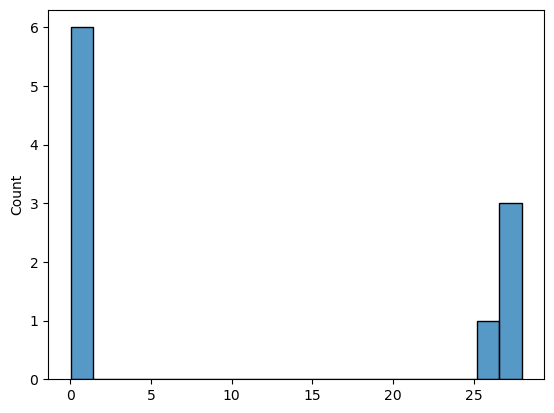

In [3]:
import seaborn as sns

sns.histplot(times,bins=20)

In [14]:
tf.reduce_mean(tf.random.uniform([10,10,10]),axis=[1,...],keepdims=)

SyntaxError: invalid syntax (148321451.py, line 1)

In [15]:
A=tf.random.uniform([30,10,10,10])


In [21]:
def right_bottom_pad(inputs,vertices):
    shape=tf.shape(inputs)
    right_padshape=tf.stack([*shape[:-2],vertices-shape[1],shape[2]]) 
    output=tf.concat([inputs,tf.zeros(right_padshape)],axis=-2)
    bottom_padshape=tf.stack([*shape[:-2],vertices,vertices-shape[2]])
    output=tf.concat([output,tf.zeros(bottom_padshape)],axis=-1)
    return output

In [22]:
right_bottom_pad(A,16)

<tf.Tensor: shape=(30, 10, 16, 16), dtype=float32, numpy=
array([[[[8.3108819e-01, 9.5711088e-01, 8.0510974e-01, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [7.9602873e-01, 2.7436948e-01, 1.3363016e-01, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [8.6384618e-01, 3.8636434e-01, 3.0642903e-01, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         ...,
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

        [[8.8516283e-01, 4.2125642e-01, 7.9686451e-01, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [2.1898222e-01, 8.0277801e-02, 5.0102711e-01, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00]

In [47]:
tf.constant([1])*tf.constant([1.])

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>

In [100]:
import tensorflow_probability as tfp
import tensorflow as tf
from tensorflow.python.framework.indexed_slices import tensor_util
from tensorflow_probability.python.internal import assert_util, parameter_properties


class DiscreteUniform(tfp.distributions.Distribution):
    def __init__(self, low, high, validate_args=False, allow_nan_stats=True, name='DiscreteUniform',dtype=tf.int32):
        parameters = dict(locals())
        with tf.name_scope(name) as name:
            self._low = tf.convert_to_tensor(low, name='low')
            self._high = tf.convert_to_tensor(high, name='high')
            if dtype is None:
                dtype = self._low.dtype
            if dtype != self._low.dtype:
                self._low = tf.cast(self._low, dtype=dtype)
                self._high = tf.cast(self._high, dtype=dtype)
            if dtype not in [tf.int32, tf.int64, tf.int16, tf.int8, tf.uint8, tf.uint16, tf.uint32, tf.uint64]:
                raise TypeError("dtype must be an integer type")
            super(DiscreteUniform, self).__init__(
                dtype=dtype,
                reparameterization_type=tfp.distributions.FULLY_REPARAMETERIZED,
                validate_args=validate_args,
                allow_nan_stats=allow_nan_stats,
                parameters=parameters,
                name=name)

    def _batch_shape_tensor(self):
        return tf.broadcast_dynamic_shape(tf.shape(self.low), tf.shape(self.high))

    def _batch_shape(self):
        return tf.broadcast_static_shape(self.low.shape, self.high.shape)

    def _event_shape_tensor(self):
        return tf.constant([], dtype=tf.int32)

    def _event_shape(self):
        return tf.TensorShape([])


    def _log_prob(self, x):
        return tf.where(
            tf.logical_and(tf.greater_equal(x, self.low), tf.less_equal(x, self.high)),
            tf.zeros_like(x),
            tf.fill(tf.shape(x), float('-inf')))

    def _prob(self, x):
        return tf.where(
            tf.logical_and(tf.greater_equal(x, self.low), tf.less_equal(x, self.high)),
            tf.ones_like(x),
            tf.zeros_like(x))

    def _cdf(self, x):
        return tf.where(
            tf.logical_and(tf.greater_equal(x, self.low), tf.less_equal(x, self.high)),
            tf.ones_like(x),
            tf.zeros_like(x))

    def _entropy(self):
        return tf.log(self.high - self.low + 1)

    def _mean(self):
        return (self.high + self.low) / 2

    def _variance(self):
        return (self.high - self.low + 1) / 12

    def _mode(self):
        return tf.floor((self.high + self.low) / 2)

    def _stddev(self):
        return tf.sqrt(self.variance())

    def _quantile(self, p):
        return tf.floor(p * (self.high - self.low + 1) + self.low)

    def _default_event_space_bijector(self):
        return tfp.bijectors.AffineScalar(shift=self.low)

    def _parameter_control_dependencies(self, is_init):
        if not self.validate_args:
            return []
        assertions = []
        if is_init != tensor_util.is_ref(self.low):
            assertions.append(assert_util.assert_non_negative(
                self.low, message='Argument `low` must be non-negative.'))
        if is_init != tensor_util.is_ref(self.high):
            assertions.append(assert_util.assert_non_negative(
                self.high, message='Argument `high` must be non-negative.'))
        return assertions

    @property
    def low(self):
        """Lower bound of the distribution."""
        return self._low

    @property
    def high(self):
        """Upper bound of the distribution."""
        return self._high

    def _parameter_properties(self, dtype, num_classes=None):
        return dict(
            low=parameter_properties.ParameterProperties(),
            high=parameter_properties.ParameterProperties())

    def _sample_control_dependencies(self, x):
        if not self.validate_args:
            return []
        assertions = []
        assertions.append(assert_util.assert_less_equal(
            x, self.high, message='Sample must be less than or equal to high.'))
        assertions.append(assert_util.assert_greater_equal(
            x, self.low, message='Sample must be greater than or equal to low.'))
        return assertions

    def _log_prob_control_dependencies(self, x):
        if not self.validate_args:
            return []
        assertions = []
        assertions.append(assert_util.assert_less_equal(
            x, self.high, message='Sample must be less than or equal to high.'))
        assertions.append(assert_util.assert_greater_equal(
            x, self.low, message='Sample must be greater than or equal to low.'))
        return assertions

    def _prob_control_dependencies(self, x):
        if not self.validate_args:
            return []
        assertions = []
        assertions.append(assert_util.assert_less_equal(
            x, self.high, message='Sample must be less than or equal to high.'))
        assertions.append(assert_util.assert_greater_equal(
            x, self.low, message='Sample must be greater than or equal to low.'))
        return assertions

    def _cdf_control_dependencies(self, x):
        if not self.validate_args:
            return []
        assertions = []
        assertions.append(assert_util.assert_less_equal(
            x, self.high, message='Sample must be less than or equal to high.'))
        assertions.append(assert_util.assert_greater_equal(
            x, self.low, message='Sample must be greater than or equal to low.'))
        return assertions

    def sample(self, sample_shape=(), seed=None, name='sample'):
        """Sample `sample_shape` values from this distribution.
        Args:
          sample_shape: `int` `Tensor` shape of the number of samples to draw.
            Default value: `[]` (i.e., scalar sample).
          seed: Python integer to seed the random number generator.
          name: Python `str` name prefixed to Ops created by this method.
            Default value: `'sample'`.
        Returns:
          sample: `sample_shape`-shaped `Tensor` of samples from this
            distribution.
        Raises:
          ValueError: if `sample_shape` is not a scalar.
        """
        with self._name_and_control_scope(name):
            sample_shape = tf.convert_to_tensor(
                sample_shape, dtype=tf.int32, name='sample_shape')
            if sample_shape.shape.ndims ==0:
                sample_shape = tf.stack([sample_shape])
            sample_rank = tf.size(sample_shape)
            params_rank=tf.rank(self._batch_shape())
            X=tf.map_fn(lambda x: tf.random.uniform(sample_shape, x[0], x[1], dtype=self.dtype, seed=seed),
                      tf.stack([self.low, self.high], axis=-1))
            return tf.transpose(X, perm=tf.concat([tf.range(params_rank, sample_rank+params_rank), tf.range(params_rank)], axis=0))

In [103]:
d=DiscreteUniform([0,0,1],[10,20,2])

In [104]:
d.sample([10,35])

<tf.Tensor: shape=(10, 35, 3), dtype=int32, numpy=
array([[[ 4, 15,  1],
        [ 4,  3,  1],
        [ 7, 11,  1],
        ...,
        [ 2, 19,  1],
        [ 3, 16,  1],
        [ 7,  8,  1]],

       [[ 1, 14,  1],
        [ 6,  2,  1],
        [ 7,  4,  1],
        ...,
        [ 9, 15,  1],
        [ 1, 10,  1],
        [ 0,  8,  1]],

       [[ 8, 15,  1],
        [ 4, 13,  1],
        [ 1,  1,  1],
        ...,
        [ 3, 14,  1],
        [ 4,  6,  1],
        [ 1, 17,  1]],

       ...,

       [[ 0, 19,  1],
        [ 6, 12,  1],
        [ 1,  6,  1],
        ...,
        [ 2, 15,  1],
        [ 0,  9,  1],
        [ 2, 13,  1]],

       [[ 5, 18,  1],
        [ 1,  2,  1],
        [ 1, 13,  1],
        ...,
        [ 3,  0,  1],
        [ 3,  6,  1],
        [ 2,  0,  1]],

       [[ 7, 17,  1],
        [ 5,  5,  1],
        [ 0,  1,  1],
        ...,
        [ 7, 14,  1],
        [ 8, 16,  1],
        [ 1,  1,  1]]], dtype=int32)>

In [53]:
tf.broadcast_dynamic_shape(tf.shape(d.low), tf.shape(d.high))

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([2], dtype=int32)>

In [54]:
def _sample_n(self, n, seed=None):
    shape = tf.concat([[n], self.batch_shape_tensor()], 0)
    return tf.map_fn(lambda x: tf.random.uniform(shape, self.low, self.high, dtype=self.dtype, seed=seed), tf.range(n))

In [75]:
tf.map_fn(lambda x:tf.random.uniform([50], x[0],x[1], dtype=d.dtype, seed=55), tf.stack([d.low,d.high],axis=-1))

<tf.Tensor: shape=(2, 50), dtype=int32, numpy=
array([[ 7,  9,  2,  2,  9,  5,  3,  1,  4,  3,  0,  3,  2,  9,  0,  3,
         6,  2,  5,  7,  4,  7,  5,  6,  4,  4,  5,  2,  2,  8,  5,  4,
         5,  2,  6,  7,  2,  5,  7,  1,  0,  6,  4,  8,  8,  8,  1,  5,
         2,  9],
       [ 9,  3,  0,  1, 11,  2,  3, 18, 13,  4,  9, 14,  7, 15,  0, 10,
        12, 13,  1, 18,  4, 17,  6, 13, 19, 11, 17, 17,  1,  0,  5,  1,
        15,  1, 14, 14,  9,  9,  0,  4, 17, 14, 16,  5,  4, 10, 15,  9,
         2, 11]], dtype=int32)>